# Submitting a large sweep job

This notebook demonstrates how to generate a large sweep job, starting with any number of randomized previews. We also show how you can submit a large job by writing the submitted job IDs to disk, which allows you to close the notebook and re-open it at a later time to query the jobs' statuses. You can then choose to download data as individual jobs complete, or wait until the entire batch has completed.

Specifically, this notebook shows how to:
  1. Prepare a large batch job and view the previews.
  2. Sweep through a batch of previews, changing a single parameter in defined increments.
  3. Submit your sweep batch.
  4. Query job status in non-blocking mode.
  5. Download the completed jobs.
  3. Compile the dataset's metadata into a dataframe for easy summarization/querying.

----- 

__Note__: The demonstration here was downsampled for easier viewing in the notebook, so the outputs in the cells will reflect small batch jobs. You can (and should!) generate batch jobs with many, many more videos that have higher resolution, better framerates, and more reps.

-----

In [1]:
import numpy as np
import infinity_tools.visionfit.api as api
from infinity_tools.common.vis.images import view_previews
from infinity_tools.common.vis.notebook import visualize_job_params
from infinity_tools.visionfit.vis import summarize_batch_results_as_dataframe, visualize_batch_results

In [2]:
TOKEN = "YOUR_TOKEN_HERE"
OUTPUT_DIR = "./tmp/"

## Prepare a large batch job and view the previews.

Before submitting our large batch for rendering full-length videos, it's useful to take a look at previews. Previews render in a fraction of the time, and allow us to figure out exactly which parameters we want to sweep through in the following cells. Here, we prepare our initial scenes with the following parameters: 

  - All videos will contain a single type of exercise (`exercise`, ARM_RAISE) 
  - All videos have 4 total reps (`num_reps`, 4)
  - The resulting distribution of gender will be evenly split (`gender`, 50% male and 50% female)
  - Each scene will be well-lit without being over-saturated (`lighting_power`, 200 to 500 units)
  - The camera will be placed between floor and table height (`camera_height`, 0.5 to 1.5 meters)
  - The resulting videos will have a low frame rate (`frame_rate`, 6 fps)
  - The resulting videos will have a resolution of 256x256 pixels (`image_height` and `image_width`, 256 pixels x 256 pixels)
  
**Users can update the specification of `job_params` to fit their exact dataset needs.**

Submitting jobs to API...


  0%|          | 0/5 [00:00<?, ?it/s]

Duration for all jobs: 28 [s]


  0%|          | 0/5 [00:00<?, ?it/s]

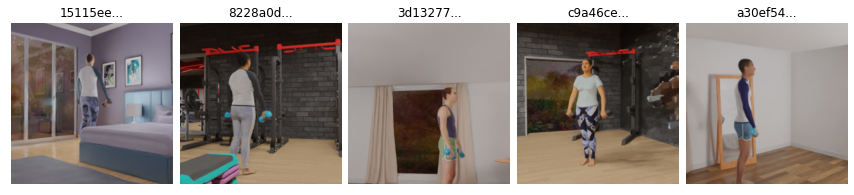

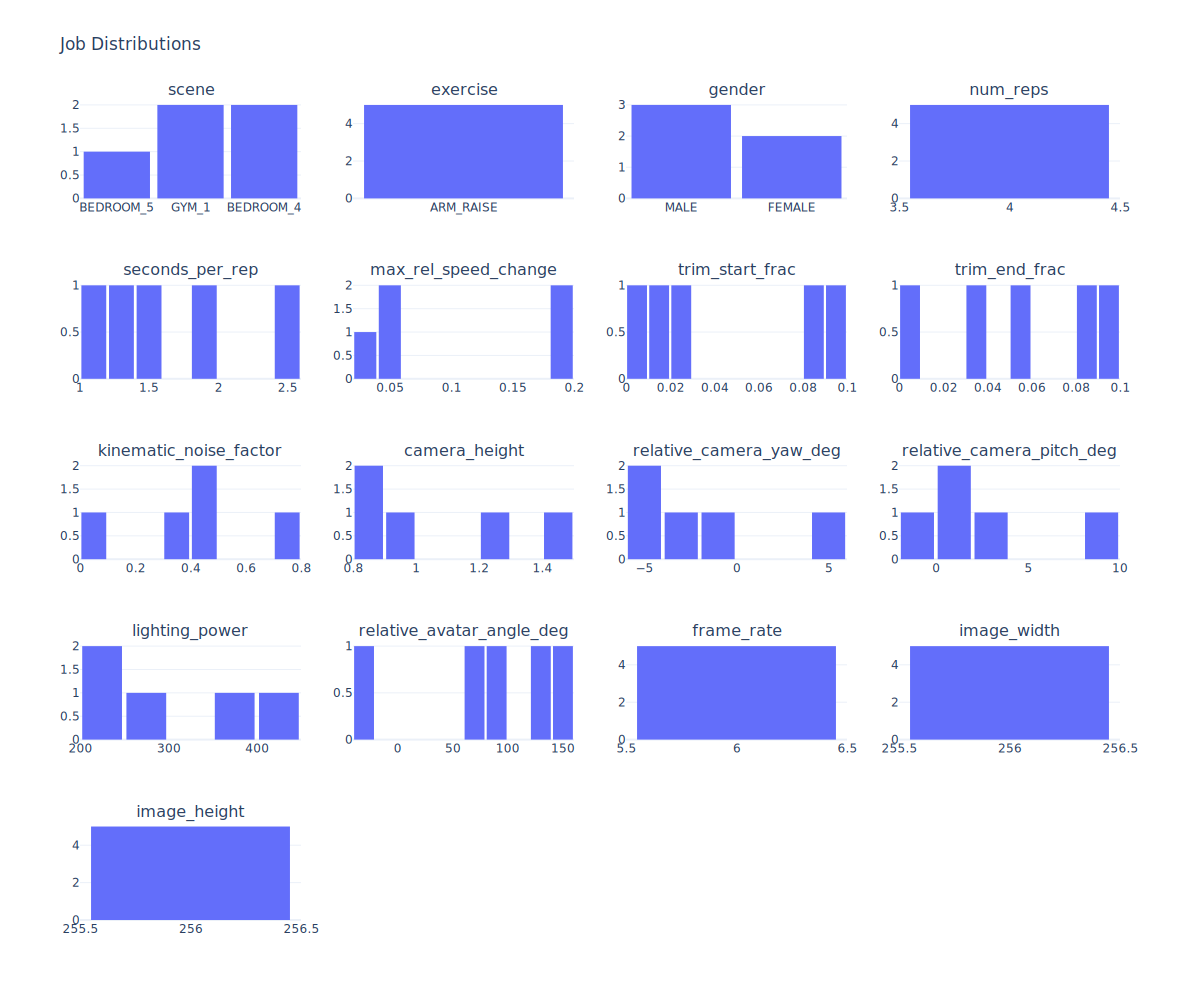

In [3]:
num_previews = 5
batch_folder_suffix = "batch_arm_raises"

# Set some initial parameters.
job_params = [
        api.sample_input(
            exercise = "ARM_RAISE",
            num_reps = 4,
            gender = api.GENDER_LST[i % 2],
            lighting_power = float(np.random.uniform(200.0, 500.0, 1)[0]),
            camera_height = float(np.random.uniform(0.5, 1.5, 1)[0]),
            frame_rate=6,
            image_height=256,
            image_width=256
        ) for i in range(num_previews)
    ]

# Submit previews.
previews_batch, previews_batch_folder = api.submit_preview_batch_to_api(
    token=TOKEN,
    preview_params=job_params,
    output_dir=OUTPUT_DIR,
    batch_folder_suffix=batch_folder_suffix,
)

# Await the batch job to complete.
completed_previews = previews_batch.await_jobs(timeout=5 * 60, polling_interval=5)
previews_folders = api.download_completed_previews(completed_previews=completed_previews, output_dir=previews_batch_folder)

#Visualize the previews in a grid, and take a look at our existing job parameter distributions.
view_previews(previews_folders)
visualize_job_params(job_params)

## Sweep through a batch of previews, changing a single parameter in defined increments.

Here, we generate **new distributions** of data from the **same base** previews shown above. We take each preview and rotate the avatar to -120 degrees, 0 degrees, and 120 degrees from the camera using the `relative_avatar_angle_deg` parameter.

Submitting jobs to API...


  0%|          | 0/15 [00:00<?, ?it/s]

Duration for all jobs: 37 [s]	


  0%|          | 0/15 [00:00<?, ?it/s]

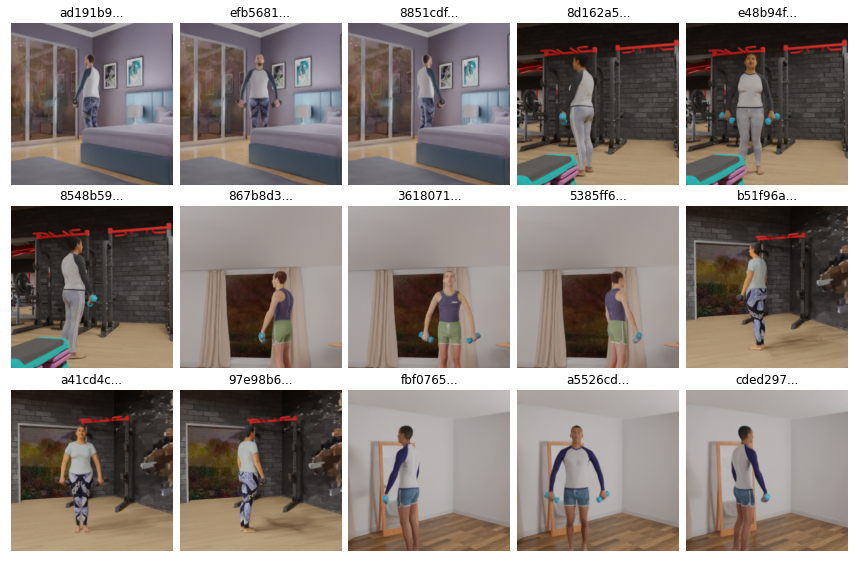

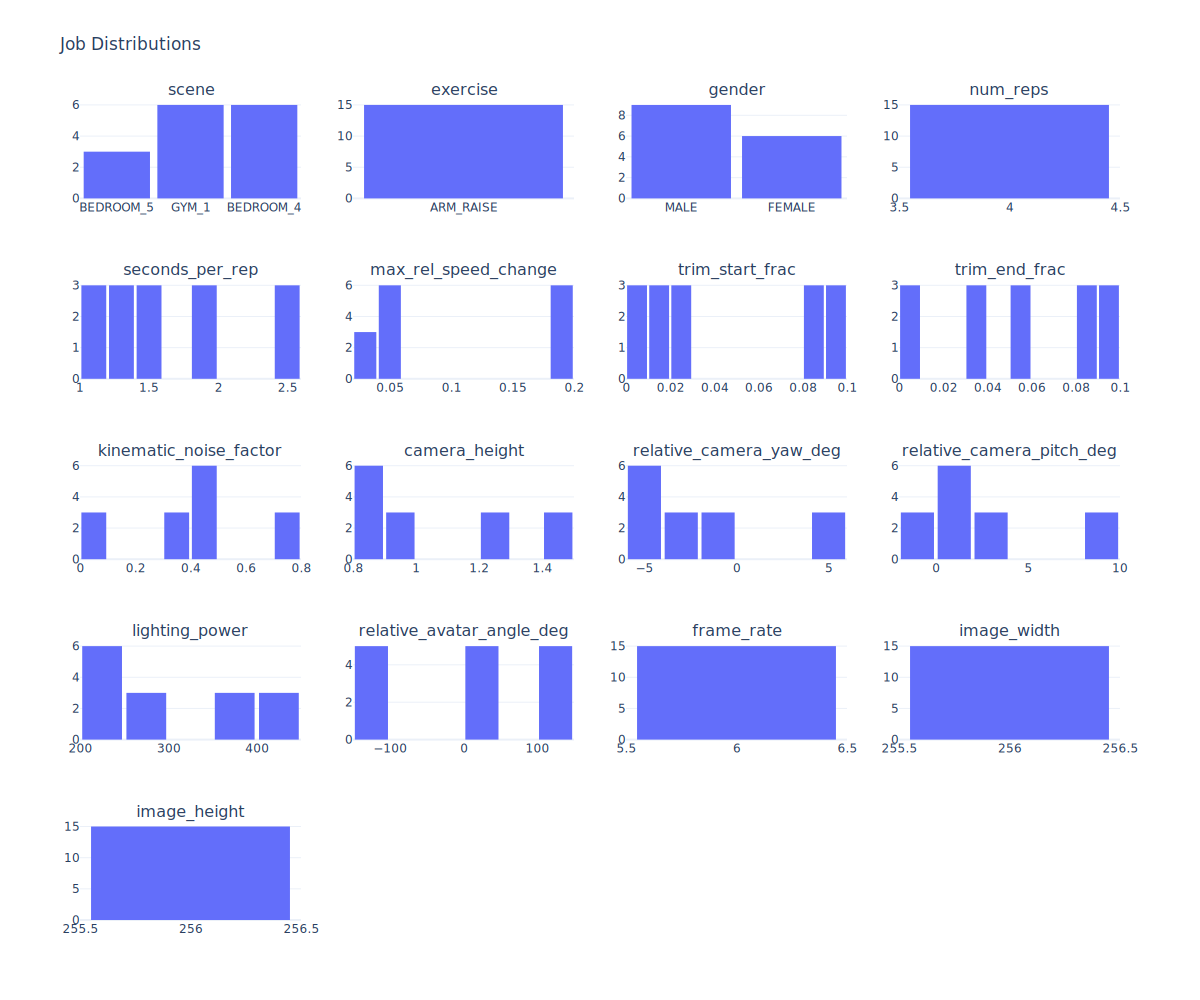

In [4]:
# Perform a parameter sweep on each of the base jobs.
override_params = [{"relative_avatar_angle_deg": rotation} for rotation in np.linspace(-120, 120, 3)]
batch_folder_suffix = "avatar_angle_sweep"

full_sweep_params = api.expand_overrides_across_each_preview_state(
    token=TOKEN,
    base_state_ids=previews_batch.job_ids,
    override_params=override_params
)

# Submit previews.
sweep_previews_batch, sweep_previews_batch_folder = api.submit_preview_batch_to_api(
    token=TOKEN,
    preview_params=full_sweep_params,
    output_dir=OUTPUT_DIR,
    batch_folder_suffix=batch_folder_suffix,
)

# Await the batch job to complete.
sweep_completed_previews = sweep_previews_batch.await_jobs(timeout=5 * 60, polling_interval=5)
sweep_previews_folders = api.download_completed_previews(completed_previews=sweep_completed_previews, output_dir=sweep_previews_batch_folder)

#Visualize the previews in a grid.
view_previews(sweep_previews_folders)
visualize_job_params(full_sweep_params)

## Submit your sweep batch job.

Now that we have a distribution of parameters that we would like to use, we can submit the large batch job to the API.

High-resolution videos can take some time to render (~20 minutes per video), so this part is **non-blocking**. That is, you can run this cell and then shut down your notebook if you like. We save your job ids to your local disk, so you can pick right up in the next section when you come back.

**NOTE: The batch name/folder should be recorded** so that it can be re-proceseed at a later time. A human-interpretable batch name can also be assigned to the batch (via `batch_folder_suffix` above) to make its folder within the output directory more obvious.

In [5]:
_, batch_folder = api.submit_video_batch_to_api(
    token=TOKEN,
    job_params=full_sweep_params,
    output_dir=OUTPUT_DIR,
    batch_folder_suffix=batch_folder_suffix,
)

print(f"Batch folder (use this folder path to poll status after restarting): {batch_folder}")

Submitting jobs to API...


  0%|          | 0/15 [00:00<?, ?it/s]

Batch folder (use this folder path to poll status after restarting): ./tmp/20220503_T172442898120_avatar_angle_sweep


## Poll status of previously submitted jobs

We next show how to check on the status of a specific batch (potentially after closing and restarting this notebook). You only need to provide a path to the associated folder. Note that you can choose to move onto the next cell and download data before all jobs have successfully completed.

In [6]:
# Reconstitute our batch process state (replace `batch_folder` with desired batch folder)
batch = api.Batch.from_batch_folder(batch_folder_path=batch_folder, token=TOKEN)

# Poll the server to see the status of our batch job.
successful_jobs, failed_jobs = batch.get_completed_jobs_valid_and_invalid()

num_successful = len(successful_jobs)
num_failed = len(failed_jobs)
num_submitted = len(batch.job_ids)

print(f"{num_successful+num_failed}/{num_submitted} submitted jobs have completed.")
print(f"{num_successful}/{num_successful+num_failed} completed jobs have a valid URL.")

Polling status of jobs...


  0%|          | 0/15 [00:00<?, ?it/s]

15/15 submitted jobs have completed.
15/15 completed jobs have a valid URL.


## Download completed jobs.

We can now download the completed jobs. We will only download the completed jobs that have a valid URL.

In [7]:
job_folders = api.download_completed_videos(completed_jobs=successful_jobs, output_dir=batch_folder)

  0%|          | 0/15 [00:00<?, ?it/s]

## Compile the dataset's metadata into a dataframe for easy summarization/querying.

Finally, we compile some of the metadata and all of the job parameters that were submitted into a dataframe. This allows us to see the distribution of the resulting dataset. In addition, we can query the dataset for specific properties, which allows us to curate a desired training set for a given ML application.

In [8]:
import pandas as pd
pd.options.display.max_columns = None

df = summarize_batch_results_as_dataframe(batch_folder)
df.round(2).query("avg_percent_in_fov > 95")

,job_path,job_id,num_frames,avg_percent_in_fov,avg_percent_occlusion,scene,exercise,gender,num_reps,seconds_per_rep,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,camera_height,relative_camera_yaw_deg,relative_camera_pitch_deg,lighting_power,relative_avatar_angle_deg,frame_rate,image_width,image_height,state
0,./tmp/20220503_T172442898120_avatar_angle_swee...,8fa4fcd6-9760-41c7-bf18-09ecbde25549,30.0,100.00,5.05,GYM_1,ARM_RAISE,FEMALE,4.0,1.26,0.04,0.01,0.04,0.45,0.81,-4.33,1.02,226.31,0.0,6.0,256.0,256.0,/tmp/tmpto8ax1pd
1,./tmp/20220503_T172442898120_avatar_angle_swee...,ce3b8c11-82bb-4f41-8013-300cab1a6913,30.0,100.00,2.61,GYM_1,ARM_RAISE,FEMALE,4.0,1.26,0.04,0.01,0.04,0.45,0.81,-4.33,1.02,226.31,-120.0,6.0,256.0,256.0,/tmp/tmp2628cmr_
2,./tmp/20220503_T172442898120_avatar_angle_swee...,9d175564-afe6-41b2-b9be-9bfd54148159,30.0,100.00,5.56,GYM_1,ARM_RAISE,FEMALE,4.0,1.26,0.04,0.01,0.04,0.45,0.81,-4.33,1.02,226.31,120.0,6.0,256.0,256.0,/tmp/tmpf7rcj0l4
3,./tmp/20220503_T172442898120_avatar_angle_swee...,4124ec90-d61a-4832-82f3-29786ccb4d26,37.0,100.00,0.89,GYM_1,ARM_RAISE,FEMALE,4.0,1.50,0.03,0.01,0.09,0.79,1.23,-2.88,0.65,435.37,0.0,6.0,256.0,256.0,/tmp/tmp1ucsl1ew
4,./tmp/20220503_T172442898120_avatar_angle_swee...,dc3b7c00-48da-46b9-8df9-e3c611b63de2,62.0,100.00,18.65,BEDROOM_5,ARM_RAISE,MALE,4.0,2.59,0.04,0.08,0.09,0.08,0.81,-0.50,-1.89,383.28,120.0,6.0,256.0,256.0,/tmp/tmp55tqvpye
5,./tmp/20220503_T172442898120_avatar_angle_swee...,6a02d2c7-691d-4ee9-b95e-01447c4f86be,37.0,100.00,1.31,GYM_1,ARM_RAISE,FEMALE,4.0,1.50,0.03,0.01,0.09,0.79,1.23,-2.88,0.65,435.37,120.0,6.0,256.0,256.0,/tmp/tmp64dy4ubf
6,./tmp/20220503_T172442898120_avatar_angle_swee...,feef9a77-63f9-4ce4-a464-7c3660845551,62.0,100.00,13.92,BEDROOM_5,ARM_RAISE,MALE,4.0,2.59,0.04,0.08,0.09,0.08,0.81,-0.50,-1.89,383.28,0.0,6.0,256.0,256.0,/tmp/tmpqjsefnu7
9,./tmp/20220503_T172442898120_avatar_angle_swee...,6a0d4136-6c93-46f4-9ddc-16972e595f24,62.0,100.00,18.73,BEDROOM_5,ARM_RAISE,MALE,4.0,2.59,0.04,0.08,0.09,0.08,0.81,-0.50,-1.89,383.28,-120.0,6.0,256.0,256.0,/tmp/tmpp76fqdpd
10,./tmp/20220503_T172442898120_avatar_angle_swee...,53806ad8-c93c-4808-94b7-e9ad72fcc1f7,25.0,96.58,1.31,BEDROOM_4,ARM_RAISE,MALE,4.0,1.20,0.18,0.10,0.01,0.49,1.45,-5.55,3.87,299.62,-120.0,6.0,256.0,256.0,/tmp/tmp1mq_8avt
12,./tmp/20220503_T172442898120_avatar_angle_swee...,9ced1f14-a8bc-4461-b83f-4f05ae9b844e,25.0,96.50,1.30,BEDROOM_4,ARM_RAISE,MALE,4.0,1.20,0.18,0.10,0.01,0.49,1.45,-5.55,3.87,299.62,0.0,6.0,256.0,256.0,/tmp/tmp5ba91j00


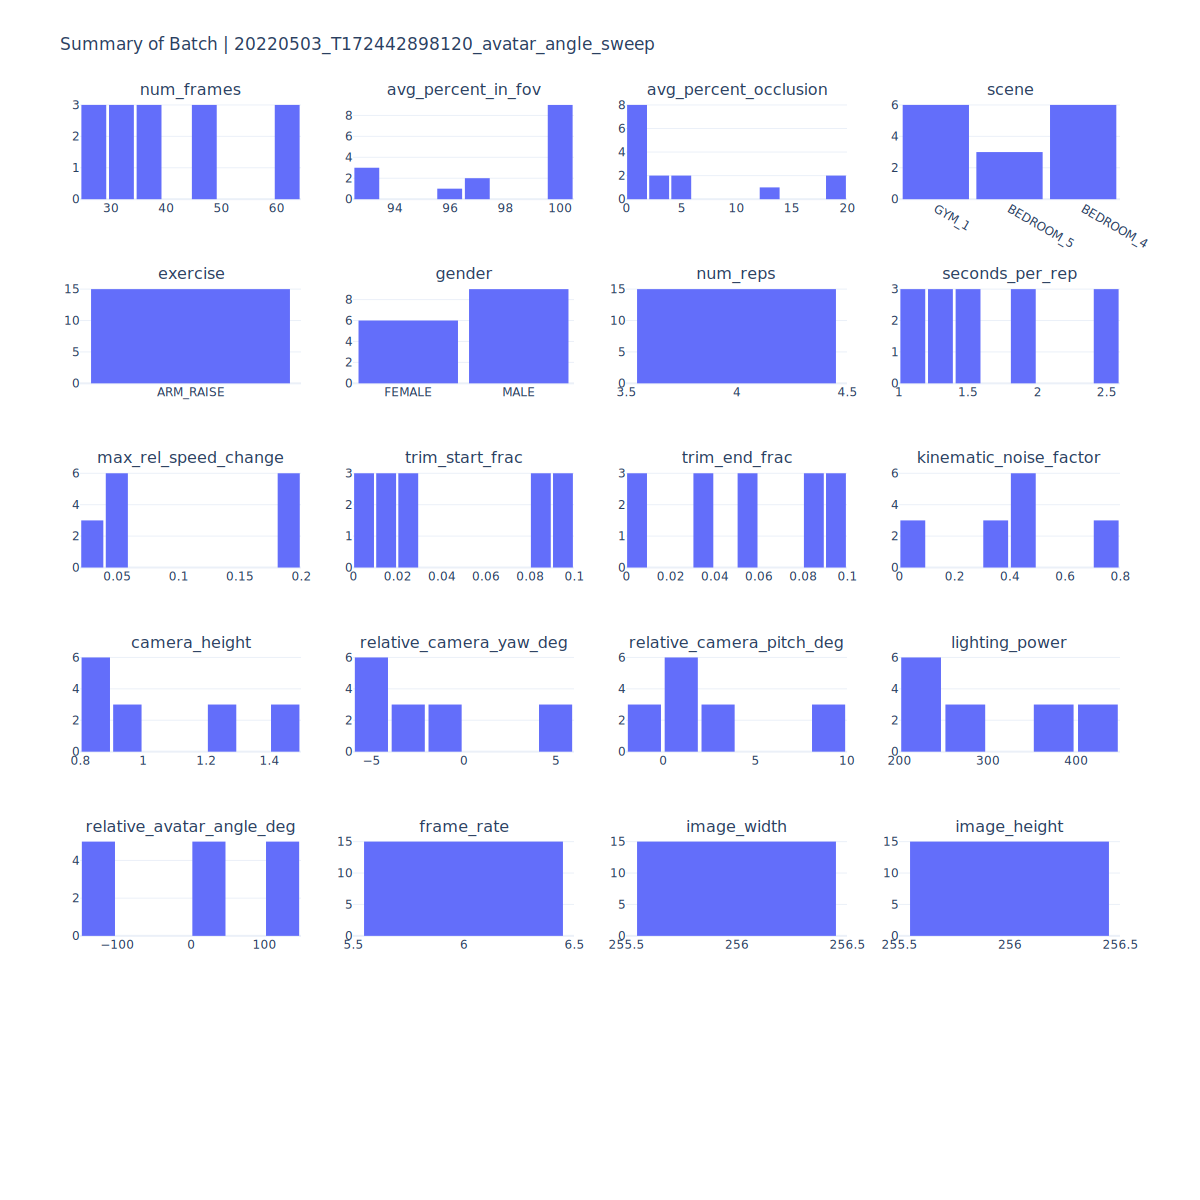

In [9]:
visualize_batch_results(batch_folder)